# Artist Identification with Convolutional Neural Networks

# STEP-1 Purpose, motivation and description:

1. Artist identification is traditionally performed by art historians and curators who have expertise and familiarity with different artists and styles of art. This is a complex and interesting problem for computers because identifying an artist does not just require object or face detection; artists can paint a wide variety of objects and scenes.

2. Additionally, many artists from the same time period will have similar styles, and some such as Pablo Picasso have painted in multiple styles and changed their style over time. Instead of hand-crafting features, we train CNNs for this problem.

3. This approach is motivated by the hypothesis that every artist has their own unique style of art and that we can improve upon existing artist identification methods by using a CNN to determine the best possible feature representation of paintings.

4. Our dataset consists of 300 paintings per artist from 57 well-known artists. We train a variety of models ranging from a simple CNN designed from scratch to a ResNet-18 network with transfer learning. Our best network achieves significantly higher classification accuracy than prior work.

5. Additionally, we perform multiple experiments to explore and understand the learned representation of our networks. Our results demonstrate that CNNs are a powerful tool for artist identification and that when asked to identify artists, they are able to learn a representation of painting style.

6. Our document has two key contributions: 
      •	Train a neural network that significantly outperforms existing approaches for artist identification. 
      •	Explore and visualize the learned feature representation for identifying artists.

7. This notebook will purely be an exploratory and hopefully concise enough attempt to explain the idea as well as using different methods to extract meaningful relations out of it.

8. My stakeholders (Art lovers, Art industries, Computer Vision works working with Arts, Museums and government) will be greatly benefitted with my model and also common people can predict artist by looking at arts.


>>Dataset Overview: In order to train a CNN to identify artists, i first obtain
a large dataset of art compiled by Kaggle that is based
on the WikiArt dataset [13]. This dataset contains roughly
100,000 paintings by 2,300 artists spanning a variety of time
periods and styles.The images vary widely in size and shape. Every image is labeled with its artist in a separate
.csv file.

# STEP-2 Data acquisition:

we first obtain a large dataset of art compiled by Kaggle that is based on the WikiArt dataset [13]. This dataset contains roughly 100,000 paintings by 2,300 artists spanning a variety of time periods and styles. The images vary widely in size and shape.

Every image is labeled with its artist in a separate .csv file. The vast majority of artists in the full dataset have fewer than 50 paintings, so in order to ensure sufficient sample sizes for training networks we use only the artists with 300 or more paintings in the dataset. Therefore, our dataset consists of 300 paintings per artist from 57 artists (about 17,000 total paintings) from a wide variety of styles and time periods.

In [2]:
#Importing all the libraries.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from IPython.display import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [3]:
df = pd.read_csv('Selected_Data/all_data_info.csv')
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


To get started we will load the necessary packages and write some functions to load the data into suitable forms for doing computation on them. This will load the images into numpy arrays that are in the shape (num_pics, channels, width, height).

In [4]:
from skimage.io import imread, imshow
from skimage import transform

# path to the saved folder and the number of pixels to use for height and width
PATH = 'images/allimages'
PIXELS = 250

def load_images(path):
    # read all of the image files in the directory
    names = [d for d in os.listdir(path) if d.endswith('.jpg')]
    
    print('Making dataset')
    # set up an empty numpy array for our images
    training_images = np.zeros((len(names), PIXELS, PIXELS, 3), dtype=np.float32)
    labels = []
    for i, n in enumerate(names):
        #print n
        img = imread(os.path.join(path, n))
        # skimage loads image as (height, width, channel) for RGB images channels = 3
        img = transform.resize(img, output_shape=(PIXELS, PIXELS , 3), preserve_range=True)
        training_images[i,:,:,:] = img
        
        # check the label on the filename and encode the label into integers
        if n.split('_')[1] == 'Durer':
            labels.append(1) 
        else:
            labels.append(0)
            
    return training_images, np.asarray(labels)

X_train, y_train = load_images(PATH)
print(X_train.shape)
print(y_train.shape)
print('Done!')

Making dataset
(1000, 250, 250, 3)
(1000,)
Done!


Once we have the data in a suitable form we can check the images to make sure that they look ok. Also to make sure that we didn't mess up the indexing for the labels somehow. 

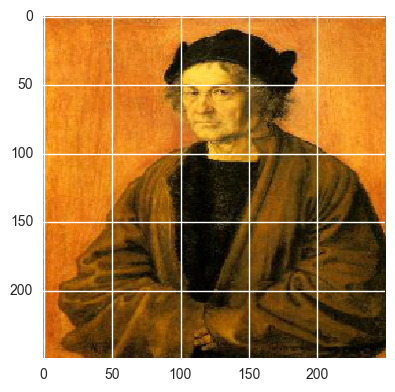

1


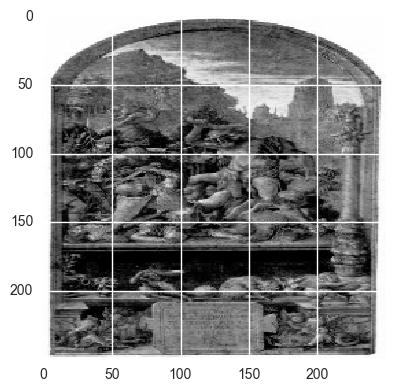

1


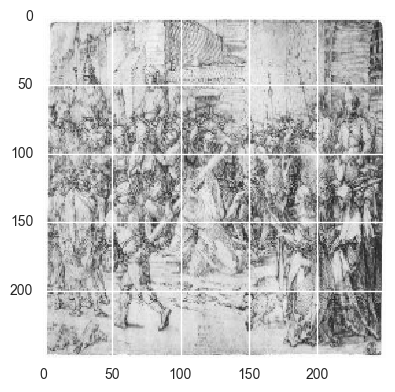

1


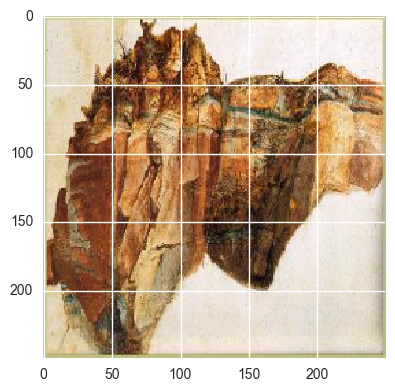

1


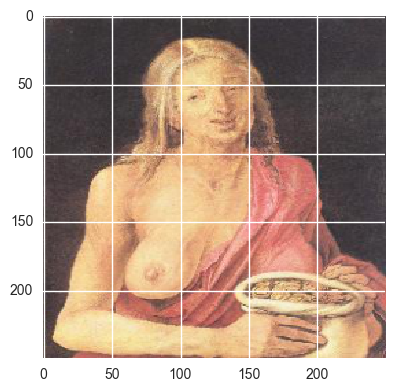

1


In [5]:
from random import randint
%matplotlib inline
from matplotlib import pyplot

def plot_sample(img):
    # we have to tranpose the image back to it's original shape
    # also for some reason imshow in skimage wants images to be float between 0-1 so we divide by it's max
    imshow(img / np.amax(img))
    pyplot.show(block=True)

# We'll pick 5 random images, plot them and print their labels
for _ in range(0,5):
    j = randint(0, X_train.shape[0])
    plot_sample(X_train[j])
    print(y_train[j])

# STEP-4 Modeling:


Now we have our data in a suitable form we can start to train some models on it. 
Since we are going to go in order from simple neural network to modern neural network we will start with a simple linear model. To get a baseline we'll implement it in sklearn. Then do the same exact thing with Keras. 

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

# do some preprocessing on the data
X_train /= np.amax(X_train)

# have to reshape the images to flat, logistic regression can't handle tensors like ConvNets can
# save this value for that later
num_features = 3*PIXELS*PIXELS

# I'm lazy, which why I like deep learning. So I'll use sklearn to shuffle and split the data
X_train, y_train = shuffle(X_train, y_train)

# should give us 40 training images and 10 testing images to eval performance on
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

logit = LogisticRegression()

logit.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = logit.predict_proba(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds[:,1])

C:\Users\Amrita\Anaconda342\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.90594951923076927

Ok so that wasn't really interesting because it's a logistic regression from sklearn. But, it's essentially the same as the most basic type of neural network. So we'll implement the that type of neural network with a neural network library. The result should be the same.

In [7]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam

logit_input = Input(shape=(num_features,), name='Input', dtype='float32')
probs = Dense(1, activation='sigmoid')(logit_input)
model = Model(input=logit_input, output=probs)

adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = model.predict(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds)

C:\Users\Amrita\Anaconda342\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("In...)`


Epoch 1/1
800/800 [==============================] - 1s - loss: 1.3035 - acc: 0.5925     


0.89372996794871795


OK so that was pretty terrible. But logistic regression is not the right tool for an image recognition task. So lets actually implement some neural networks.
We'll first take the same response that the community had when it was pointed out that a perceptron couldn't solve XOR. The following code will produce a multilayer perceptron. 

In [8]:
mlp_input = Input(shape=(num_features,), name='Input', dtype='float32')

fc1 = Dense(32, activation='relu')(mlp_input)
fc2 = Dense(32, activation='relu')(fc1)


probs = Dense(1, activation='sigmoid')(fc2)

model = Model(input=mlp_input, output=probs)
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = model.predict(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds)

C:\Users\Amrita\Anaconda342\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("In...)`


Epoch 1/1
800/800 [==============================] - 5s - loss: 7.6129 - acc: 0.5050     


0.5

# Convolutional Neural Networks

So now we'll get to the architectures that kick started the deep learning hype in 2012. Convolutional neural networks. This is a pretty tiny one compared to todays standards, but it should also run fine on a CPU. So it will be easy to play with on a laptop.

Data pre­processing and data augmentation:

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. 

This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. 
This class allows you to:
configure random transformations and normalization operations to be done on your image data during training instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). 
These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.


In [13]:
datagen = ImageDataGenerator(
         rotation_range=40,
         width_shift_range=0.2,
         height_shift_range=0.2,
         shear_range=0.2,
         zoom_range=0.2,
         horizontal_flip=True,
         fill_mode='nearest')

img = load_img('images/train/Albrecht_Durer_12130.jpg')   #This is a PIL Image
X = img_to_array(img)   #This is the numpy array
X = X.reshape((1,) + X.shape)

#The .flow() command below generates batches of randomly transformed images and saves the results to the 'preview/' directory.

i = 0

for batch in datagen.flow(X, batch_size=1, save_to_dir='images/preview', save_prefix='Durer', save_format='jpg'):
    i +=1
    if i > 20:
        break #otherwise the generator would loop indefinitely
        

rotation_range is a value in degrees (0­180), a range within which to randomly rotate pictures

width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally

rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0­255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor. 

shear_range is for randomly applying shearing transformations.

zoom_range is for randomly zooming inside pictures.

horizontal_flip is for randomly flipping half of the images horizontally ­­relevant when there are no assumptions of horizontal assymetry (e.g. real­world pictures)

fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [14]:
X.shape

(1, 342, 256, 3)

# STEP-3 Data Cleaning:

1. Because the art in the dataset comes in a variety of shapes and sizes, we modify the images before passing them into our CNNs. First, we zero-center the images and normalize them.

2. Next, we take a 224x224 crop of each input image. While training the network, we randomly horizontally flip the input image with a 50% probability and then take a crop of a random section of the painting. This randomness adds variety to the training data and helps avoid overfit.

3. For the validation and test images, we always take a 224x224 center crop of the image to ensure stable and reproducible results. We do not rescale paintings before taking crops in order to preserve their pixel-level details. Our hypothesis is that artist style is present everywhere in an image and not limited to specific areas, so crops of paintings should still contain enough information for a CNN to determine style.

4. Also, we hypothesize that in order to determine style, it is important to preserve the minute details that might be lost with rescaling. Given the large number of entries in the dataset and the processing that is needed before passing them into our CNNs, we do not load our entire dataset into memory but store it on disk and load minibatches one at a time. This slows down training due to requiring additional disk read time, but allows us to train using our entire dataset and to use larger crops of our paintings than would be possible otherwise, improving overall accuracy.

5. We develop and train three different CNN architectures to identify artists. Every network we use takes as input a 3x224x224 RGB image and outputs the scores for each of the 57 artists present in our dataset.

6. For all of our networks, we use a softmax classifier with cross-entropy loss. This loss function ensures that our network is constantly trying to maximize the score of the correct artists of its training examples relative to other artists during training.

# Training a small convnet from scratch

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. 

For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Your main focus for fighting overfitting should be the entropic capacity of your model ­­how much information your model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better.


There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.

In our case we will use a very small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).


In [22]:
batch_size = 16

#this is the augmentation configuration we will use for the training

train_datagen = ImageDataGenerator(
         rescale=1./255,
         rotation_range=40,
         width_shift_range=0.2,
         height_shift_range=0.2,
         shear_range=0.2,
         zoom_range=0.2,
         horizontal_flip=True,
         fill_mode='nearest')

#this is the augmentation configuration we will use for testing:
#only rescaling

test_datagen = ImageDataGenerator(rescale=1./255)

#this is a generator that will read pictures found in subfolders of images/train and indefinitely generate batches 
#of augmented image data.

train_generator = train_datagen.flow_from_directory(
         'images/train',
          target_size=(250,250),  #all images will be resized to 250 X 250
          batch_size=batch_size,
          class_mode='binary')  #since we use binary_crossentropy loss, we need binary label

#this is similar generator, for test data
test_generator = test_datagen.flow_from_directory(
         'images/test',
          target_size=(250,250),  #all images will be resized to 250 X 250
          batch_size=batch_size,
          class_mode='binary')  #since we use binary_crossentropy loss, we need binary label


Found 880 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [29]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(250, 250, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps( height, width, features)

#on top of it we stick two fully-connected layers. We end the model with a single model with a single unit
#and a sigmoid activation, which is perfect for a binary classification. To go with it we will also use the binary_crossentropy 
#loss to train our model.

model.add(Flatten())   #this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [ ]:
#we can now use these generators to train our model.

# STEP-5 Evaluation:

In [30]:
model.fit_generator(
        train_generator,
        steps_per_epoch=880 // batch_size,
        epochs=50,
        validation_data=test_generator,
        validation_steps=120 // batch_size)

model.save_weights('first_try.h5')

Epoch 1/50
55/55 [==============================] - 129s - loss: 0.7433 - acc: 0.6784 - val_loss: 0.3467 - val_acc: 0.8571
Epoch 2/50
55/55 [==============================] - 133s - loss: 0.4634 - acc: 0.8125 - val_loss: 0.3005 - val_acc: 0.9038
Epoch 3/50
55/55 [==============================] - 133s - loss: 0.4333 - acc: 0.8182 - val_loss: 0.3206 - val_acc: 0.8750
Epoch 4/50
55/55 [==============================] - 137s - loss: 0.4102 - acc: 0.8330 - val_loss: 0.2893 - val_acc: 0.8558
Epoch 5/50
55/55 [==============================] - 130s - loss: 0.3957 - acc: 0.8455 - val_loss: 0.3237 - val_acc: 0.8942
Epoch 6/50
55/55 [==============================] - 132s - loss: 0.4180 - acc: 0.8455 - val_loss: 0.2867 - val_acc: 0.8942
Epoch 7/50
55/55 [==============================] - 129s - loss: 0.3757 - acc: 0.8489 - val_loss: 0.4357 - val_acc: 0.7500
Epoch 8/50
55/55 [==============================] - 130s - loss: 0.3849 - acc: 0.8409 - val_loss: 0.2344 - val_acc: 0.8942
Epoch 9/50
55/55

# STEP-6 Conclusion:

This approach gets us to a validation accuracy of 0.90-0.93 after 50 epochs (a number that was picked arbitrarily ­­because the model is small and uses aggressive dropout, it does not seem to be overfitting too much by that point).

Note that the variance of the validation accuracy is fairly high, both because accuracy is a high­variance metric and because we only use 120 validation samples. A good validation strategy in such cases would be to do k­fold cross­validation, but this would require training k models for every evaluation round.
